In [1]:
import os
import sys
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from modules import *
from execution import *
import json

In [2]:
gpt2 = {'l': 1024, 'e': 1600, 'h': 32, 'depth': 48}
gpt3 = {'l': 2048, 'e': 12288, 'h': 96, 'depth': 96}
gpt3_1T = {'l': 2048, 'e': 25600, 'h': 160, 'depth': 180}
gpt3_lowdepth = {'l': 2048, 'e': 12288, 'h': 256, 'depth': 96 // 8}
vit_era5 = {'l': 64800, 'e': 5120, 'h': 32, 'depth': 24}
vit_era5_big = {'l': 64800, 'e': 6144, 'h': 32, 'depth': 32}
vit_era5_1px = {'l': 1036800, 'e': 6144, 'h': 32, 'depth': 32}
vit_era5_1px_big = {'l': 1036800, 'e': 12288, 'h': 96, 'depth': 96}
### model
model = gpt3_1T
# model = vit_era5_1px
global_batch = 1024
l = model['l']
e = model['e']
f = 4 * e
model['f'] = f
h = model['h']
depth = model['depth']
print(model)

{'l': 2048, 'e': 25600, 'h': 160, 'depth': 180, 'f': 102400}


In [3]:
with open('config.json', 'r') as file:
    system = json.load(file)

In [4]:
def print_df(df_mlp, df_sa):
    cols = df_mlp.columns.tolist()
    layer_track_cols = ['activation_buffer', 'weights_mem', 
                        'weights_grad_mem', 'flops_fwd', 'flops_bwd', 
                        't_fwd', 't_fwd_comm', 't_bwd', 't_bwd_comm']
    display(df_mlp[cols])
    display(df_mlp[layer_track_cols].sum())
    display(df_sa[cols])
    display(df_sa[layer_track_cols].sum()) 

In [5]:
# m = 16 # total model parallel devices
# pp = 2
# tp = m // pp
# dp = 128
# b = 1
# m1 = tp
# t1 = 'nvlink' if m1 <= system['nvlink_size'] else 'ib'
# df_mlp = mlp_1d(b, l, e, f, depth, parallelism={'m': m1}, topology={'t': t1})
# df_sa = sa_1d(b, l, e, h, depth, parallelism={'m': m1}, topology={'t': t1}, flash_attention=True)
# print_df(df_mlp, df_sa)
# _,_ = totals(df_mlp, df_sa, model['depth'], pp=pp, dp=1, verbose=True)

In [6]:
n_gpus = 2**np.array([i for i in range(2,14)])
# n_gpus = [16384]
global_batch_size = 4096

with open('config.json', 'r') as file:
    system = json.load(file)
system['nvlink_size'] = 32

configs = execute_1d(model, n_gpus, global_batch_size=global_batch_size, system=system, verbose=False)

for n, c in zip(n_gpus,configs):
    print("n = {}, config = {}".format(n, c))


n = 4, config = ([], 0, inf)
n = 8, config = ([], 0, inf)
n = 16, config = ([], 0, inf)
n = 32, config = ([], 0, inf)
n = 64, config = ([], 0, inf)
n = 128, config = ([], 0, inf)
n = 256, config = ([], 0, inf)
n = 512, config = ([], 0, inf)
n = 1024, config = ({'dp': 8, 'tp': 64, 'pp': 2, 'mbs': 1}, 15.145195391922767, 78.97050752000001)
n = 2048, config = ({'dp': 16, 'tp': 32, 'pp': 4, 'mbs': 1}, 33.9845089832909, 77.50545280000001)
n = 4096, config = ({'dp': 32, 'tp': 32, 'pp': 4, 'mbs': 1}, 67.19075652350323, 70.50545280000001)
n = 8192, config = ({'dp': 64, 'tp': 32, 'pp': 4, 'mbs': 1}, 131.3730098566148, 70.50545280000001)


nvs = 2: t = 49.61716980285856, n = 8192
nvs = 2: configs = [[], [], [], [], [], [], [], [], {'dp': 8, 'tp': 64, 'pp': 2, 'mbs': 1}, {'dp': 16, 'tp': 32, 'pp': 4, 'mbs': 1}, {'dp': 32, 'tp': 32, 'pp': 4, 'mbs': 1}, {'dp': 64, 'tp': 32, 'pp': 4, 'mbs': 1}], n = [1024 2048 4096 8192]
nvs = 4: t = 74.26643185104318, n = 8192
nvs = 4: configs = [{'dp': 8, 'tp': 64, 'pp': 2, 'mbs': 1}, {'dp': 16, 'tp': 32, 'pp': 4, 'mbs': 1}, {'dp': 32, 'tp': 32, 'pp': 4, 'mbs': 1}, {'dp': 64, 'tp': 32, 'pp': 4, 'mbs': 1}], n = [1024 2048 4096 8192]
nvs = 8: t = 98.81038621869716, n = 8192
nvs = 8: configs = [{'dp': 8, 'tp': 64, 'pp': 2, 'mbs': 1}, {'dp': 16, 'tp': 32, 'pp': 4, 'mbs': 1}, {'dp': 32, 'tp': 32, 'pp': 4, 'mbs': 1}, {'dp': 64, 'tp': 32, 'pp': 4, 'mbs': 1}], n = [1024 2048 4096 8192]
nvs = 16: t = 118.37018090856364, n = 8192
nvs = 16: configs = [{'dp': 8, 'tp': 64, 'pp': 2, 'mbs': 1}, {'dp': 16, 'tp': 32, 'pp': 4, 'mbs': 1}, {'dp': 32, 'tp': 32, 'pp': 4, 'mbs': 1}, {'dp': 64, 'tp': 32, 'pp': 4,

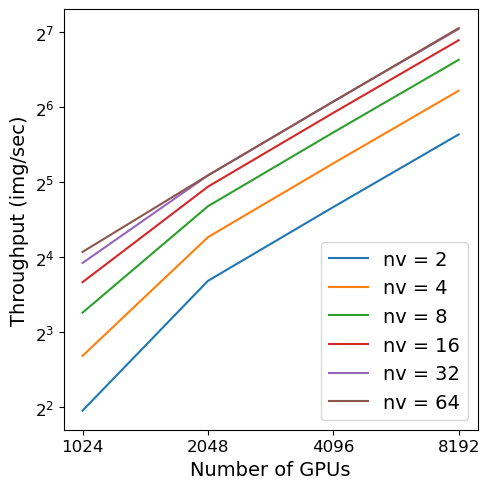

In [7]:
fig, axs = plt.subplots(1,1,figsize=(5,5), tight_layout=True) 
axs.tick_params(axis='both', which='major', labelsize=12)
axs.tick_params(axis='both', which='minor', labelsize=12)
n_gpus = 2**np.array([i for i in range(2,14)])
global_batch_size = 4096
with open('config.json', 'r') as file:
    system = json.load(file)

nvs_list = [2, 4, 8, 16, 32, 64]
feasible = None
verbose = True
for nvs in nvs_list:
    system['nvlink_size'] = nvs
    configs = execute_1d(model, n_gpus, global_batch_size=global_batch_size, system=system, verbose=False)
    t = [c[1] for c in configs]
    conf = [c[0] for c in configs]
    # conf = [/
    if not feasible:
        feasible = next((i for i, x in enumerate(t) if x), None)
        t = t[feasible:]
        n_gpus = n_gpus[feasible:]
        
    axs.plot(n_gpus, t)
    print('nvs = {}: t = {}, n = {}'.format(nvs, t[-1], n_gpus[-1]))
    if verbose:
        print('nvs = {}: configs = {}, n = {}'.format(nvs, conf, n_gpus))
    axs.set_yscale('log', base=2)
    axs.set_xscale('log', base=2)
    axs.set_xticks(n_gpus)
    axs.set_xticklabels(n_gpus)
    axs.set_xlabel('Number of GPUs', fontsize=14)
    axs.set_ylabel('Throughput (img/sec)', fontsize=14)
axs.legend(['nv = {}'.format(n) for n in nvs_list], fontsize=14)

In [2]:
# def factors(n):
#     for c in range(1, n+1):
#         if n % c == 0:
#             yield c

# def tp1d_candidates(n, heads, hidden):
#     # candidates for tensor parallelism in 1D
#     for c in factors(n):
#         if c <= heads and c <= hidden:
#             yield c

# def tp2d_candidates(n, tp1, heads, hidden, sequence):
#     # candidates for tensor parallelism in 2D (this includes the sequence dim)
#     # tp1 is candidates for the 1st dim of parallelism (hidden, heads)
    
#     tp2 = n // tp1 # use remaining for other dim (seq) 
#     for c in factors(tp2):
#         if c <= sequence:
#             yield c

# def pp_candidates(n, tp, depth):
#     max_pp = min(n // tp, depth)
#     for c in factors(max_pp):
#         if n % (tp * c) == 0 and depth % c == 0: # assume equal pp
#             yield c

# def get_dp(n, tp, pp):
#     assert n % (tp * pp) == 0
#     return n // (tp * pp)

# def micro_batch_size_candidates(global_batch_size, tp, pp, dp):
#     assert global_batch_size % dp == 0 # dont think this matters too much
#     local_batch_size = global_batch_size // dp
#     if pp == 1:
#         yield local_batch_size
#     else:
#         for c in factors(local_batch_size):
#             yield c


In [1]:
# n_gpus = [128]
# global_batch_size = 256
# for n in n_gpus:
#     for tp1 in tp1d_candidates(n, h, f):
#         for tp2 in tp2d_candidates(n, tp1, h, f, l):
#             tp = tp1 * tp2
#             for pp in pp_candidates(n, tp, depth):
#                 dp = get_dp(n, tp, pp)
#                 if dp > global_batch_size:
#                     continue
#                 for micro_batch_size in micro_batch_size_candidates(global_batch_size, tp, pp, dp):
#                     # print("mbs = {}, dp = {}, tp = {}, pp = {}".format(micro_batch_size, dp, tp, pp))
#                     print("mbs = {}, dp = {}, tp1 = {}, tp2 = {}, pp = {}, prod = {}".format(micro_batch_size, dp, tp1, tp2, pp, pp*tp1*tp2*dp))
#                     c = (dp, tp1, tp2, pp, micro_batch_size)